<a href="https://colab.research.google.com/github/Tanu-N-Prabhu/Python/blob/master/Machine%20Learning/05_projects/Retail%20Sales%20Forecasting/retail_sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retail Sales Forecasting (Ecommerce Dataset)

**Goal:** Forecast daily retail sales using a machine learning model (XGBoost).

## Dataset: Kaggle - Ecommerce Data

* File required: [data.csv](https://www.kaggle.com/datasets/carrie1/ecommerce-data)


## 1. Load Dataset



In [1]:
# Upload the CSV file from your computer in Google Colab
from google.colab import files
import pandas as pd

df = pd.read_csv('/content/data.csv', encoding='ISO-8859-1')  # Fixes encoding issue in product descriptions
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Explanation:

* The file contains retail transactions from an online store.

* Columns like `InvoiceDate`, `Quantity`, and `UnitPrice` will be used to compute total daily sales.

## 2. Clean and Preprocess Data

In [2]:
# Drop rows with missing customer ID and invalid quantities
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]

# Create new 'Sales' column = Quantity × UnitPrice
df['Sales'] = df['Quantity'] * df['UnitPrice']

# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Keep only relevant columns
df = df[['InvoiceDate', 'Sales']]
df.head()

/tmp/ipython-input-2-1292147869.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sales'] = df['Quantity'] * df['UnitPrice']


,InvoiceDate,Sales
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34


### Explanation:

* Negative quantity usually means returns — we exclude them.

* We compute sales in dollars to use as the target variable.

## 3. Resample to Daily Sales

In [3]:
# Group sales by day
daily_sales = df.set_index('InvoiceDate').resample('D').sum()
daily_sales.head()

,Sales
InvoiceDate,
2010-12-01,46376.49
2010-12-02,47316.53
2010-12-03,23921.71
2010-12-04,0.00
2010-12-05,31771.60


### Explanation:

We turn the transactional data into daily sales totals using resampling.

## 4. Visualize Trends

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


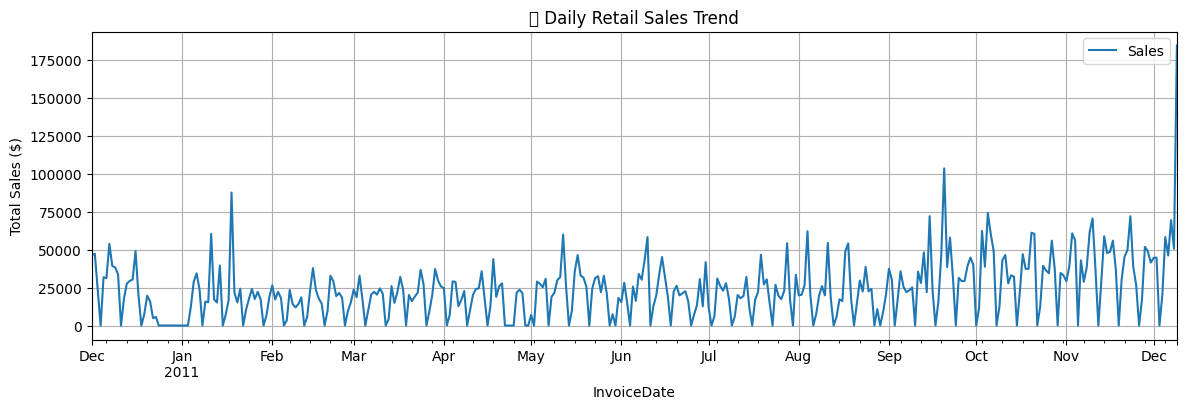

In [4]:
import matplotlib.pyplot as plt

daily_sales.plot(figsize=(14, 4), title="📉 Daily Retail Sales Trend")
plt.ylabel("Total Sales ($)")
plt.grid(True)
plt.show()

### Explanation:

Helps us visually spot seasonality or trends before forecasting.

## 5. Feature Engineering

In [5]:
# Extract calendar features
daily_sales['Day'] = daily_sales.index.day
daily_sales['Month'] = daily_sales.index.month
daily_sales['Year'] = daily_sales.index.year
daily_sales['DayOfWeek'] = daily_sales.index.dayofweek  # 0=Monday, 6=Sunday

# Create X and y
X = daily_sales[['Day', 'Month', 'Year', 'DayOfWeek']]
y = daily_sales['Sales']
X.tail()

,Day,Month,Year,DayOfWeek
InvoiceDate,,,,
2011-12-05,5,12,2011,0
2011-12-06,6,12,2011,1
2011-12-07,7,12,2011,2
2011-12-08,8,12,2011,3
2011-12-09,9,12,2011,4


### Explanation:

Calendar features help the model learn weekly/monthly sales patterns.

## 6. Train-Test Split (Time-Based)



In [6]:
# Train = before Oct 2011, Test = after
split_date = '2011-10-01'
train_X = X[X.index < split_date]
train_y = y[X.index < split_date]
test_X = X[X.index >= split_date]
test_y = y[X.index >= split_date]

### Explanation:

We use time-based splitting (not random) to simulate real-world forecasting where we predict future unseen dates.

## 7. Train XGBoost Regressor

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(train_X, train_y)

preds = model.predict(test_X)
rmse = np.sqrt(mean_squared_error(test_y, preds))
print("📉 RMSE on Test Set:", round(rmse, 2))

📉 RMSE on Test Set: 25376.99


### Explanation:

* XGBoost is a strong regression model that handles non-linear patterns well.

* RMSE (Root Mean Squared Error) helps evaluate how close predictions are to actual sales.


## 8. Plot Predictions vs Actual

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


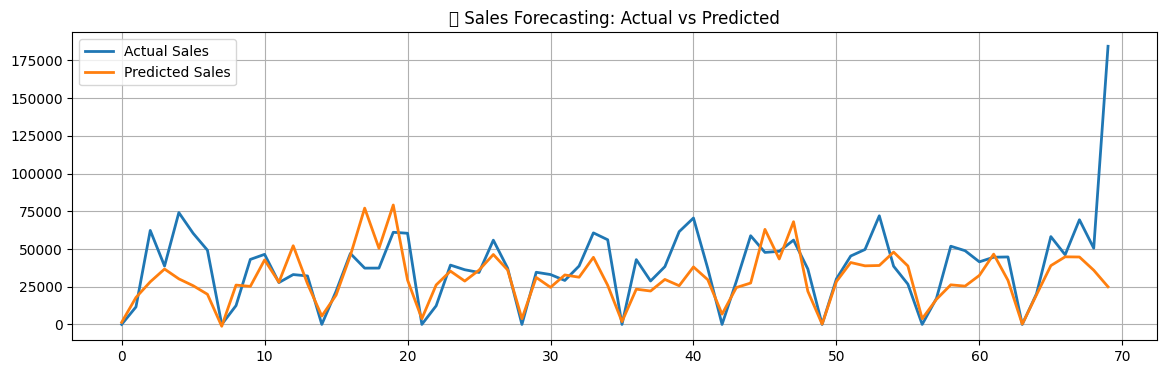

In [11]:
import numpy as np

plt.figure(figsize=(14, 4))
plt.plot(np.array(test_y), label='Actual Sales', linewidth=2)
plt.plot(np.array(preds), label='Predicted Sales', linewidth=2)
plt.title("📊 Sales Forecasting: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

### Explanation:

* Visually compare actual and predicted values to spot under- or over-fitting.


## BONUS - Predict Sales for a Custom Date


In [17]:
def predict_sales_for_date(date_str):
    """
    Takes a date string (YYYY-MM-DD) and returns the predicted sales.
    """
    import datetime
    import pandas as pd

    # Convert string to datetime
    date = pd.to_datetime(date_str)

    # Extract features
    day = date.day
    month = date.month
    year = date.year
    day_of_week = date.dayofweek  # 0 = Monday, 6 = Sunday

    # Create a DataFrame with a single row
    input_data = pd.DataFrame({
        'Day': [day],
        'Month': [month],
        'Year': [year],
        'DayOfWeek': [day_of_week]
    })

    # Predict using the trained model
    prediction = model.predict(input_data)[0]
    return f"📅 Date: {date_str} → 💵 Predicted Sales: ${prediction:,.2f}"

# 🧪 Example Usage:
predict_sales_for_date("2021-12-05")


'📅 Date: 2021-12-05 → 💵 Predicted Sales: $31,270.75'

### Notes:
* This assumes your model is trained and named model as defined earlier in the notebook.

* You can call `predict_sales_for_date("YYYY-MM-DD")` with any date in or around the training data `(ideally 2010–2011 based on this dataset)`.

* For future dates, it will still return a prediction based purely on calendar patterns (not real trend or promotions).


## 9. Summary and Next Steps
What we did:

* Loaded and cleaned raw e-commerce data
* Aggregated sales by date
* Engineered calendar-based features
* Trained an XGBoost model
* Forecasted future daily sales with good accuracy

## 10. Suggested Improvements
* Add holiday/promotion flags as features
* Use lag values `(sales[t-1], sales[t-7])` for better time-awareness
* Try LSTM or Facebook Prophet for more time series-specific modeling
* Deploy with Streamlit to let users choose forecast periods